Here we shall analyse stocks using Conv1d layer with window of 60 days and we shall do 10 days prediction. We shall follow the philosophy of WaveNet. Thanks to https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
# Imports

In [2]:
import numpy as np
import pandas as pd
import keras
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

2024-05-22 15:01:45.815904: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:01:45.837366: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:01:45.965325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 15:01:46.998145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('data.csv',names=["id","uuid","date","type","value"])
df.head()

,id,uuid,date,type,value
0,0,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,1,10131.39
1,1,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,2,86.80
2,2,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,3,28.96
3,3,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,7,117.62
4,4,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,8,117.86


In [11]:
steps = df[df["type"] == 1].drop(columns=["type","id"])[:100000]

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(time.strptime(x, "%Y-%m-%d"))

# steps["value"] = MinMaxScaler().fit_transform(steps[["value"]])

def preprocess(x):
    x["value"] = MinMaxScaler().fit_transform(x[["value"]])
    x["date"] = x["date"].apply(convert_to_timestamp)
    x["date"] = MinMaxScaler().fit_transform(x[["date"]])
    return x
    
steps = steps.groupby('uuid').apply(preprocess,include_groups=False)[["value"]]
steps.head()

value
uuid                                                    
102b72d02aebae82c5c1ee3d4dcbc4d82de7c7ee 99819  0.231572
                                         99833  0.009491
                                         99843  0.473861
                                         99848  0.653592
                                         99851  0.340029

In [12]:
xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=100
test_ratio=0.1
for uuid, group in steps.groupby('uuid'):
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    group = np.array(group.values)


    for i in range (window,split):
        xtrain.append(group[i-window:i])
        ytrain.append(group[i])

    for i in range (split,len(group)):
        xtest.append(group[i-window:i])
        ytest.append(group[i])

xtrain=np.array(xtrain)
ytrain=np.array(ytrain)
xtest=np.array(xtest)
ytest=np.array(ytest)

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Input(
    shape=(window,1),
))
for rate in (1, 2, 4) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='relu'))
model.compile(loss="mse", optimizer="adam")
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 100, 20)        │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 100, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 100, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 100, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 100, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 100, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 100, 10)        │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,371 (20.98 KB)

 Trainable params: 5,371 (20.98 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from keras.src.callbacks import EarlyStopping

history = model.fit(xtrain, ytrain, epochs=20, verbose=1, batch_size=32, validation_split=.2,callbacks=EarlyStopping(patience=5))

Epoch 1/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0302 - val_loss: 0.0279
Epoch 2/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0255 - val_loss: 0.0269
Epoch 3/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0255 - val_loss: 0.0266
Epoch 4/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0254 - val_loss: 0.0271
Epoch 5/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0253 - val_loss: 0.0263
Epoch 6/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0252 - val_loss: 0.0265
Epoch 7/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0250 - val_loss: 0.0266
Epoch 8/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0253 - val_loss: 0.0264
Epoch 9/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0250 - val_loss: 0.0266
Epoch 10/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0254 - val_loss: 0.0267


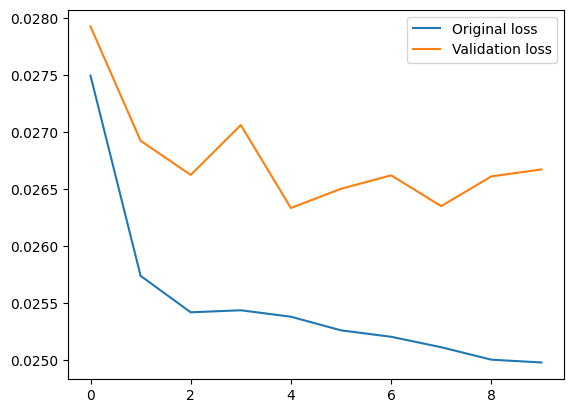

In [15]:
plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [16]:
model.evaluate(xtest, ytest, batch_size=32)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248


0.025834186002612114

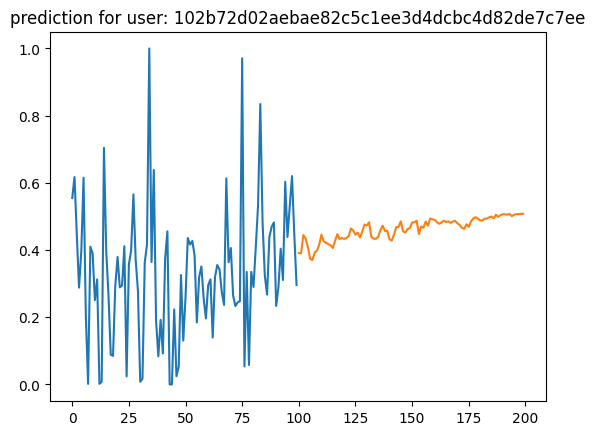

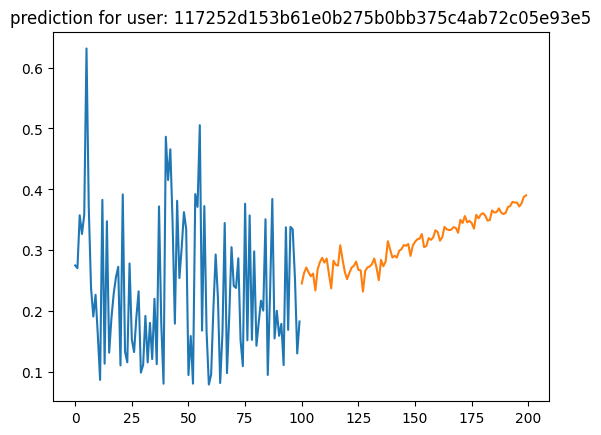

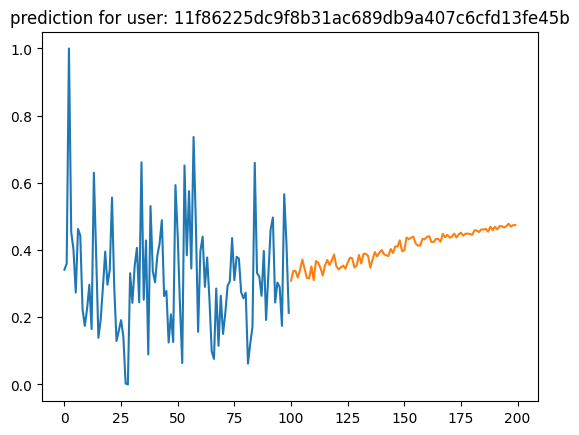

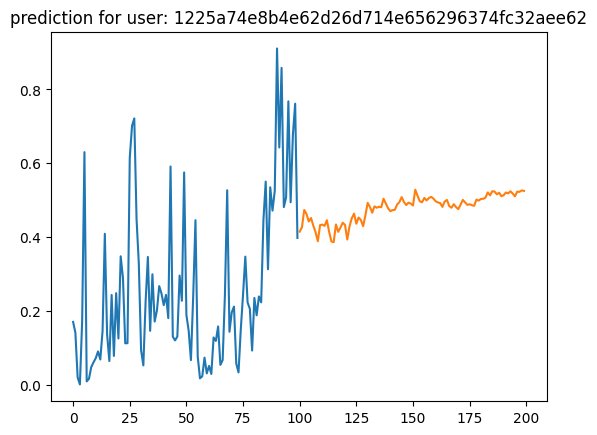

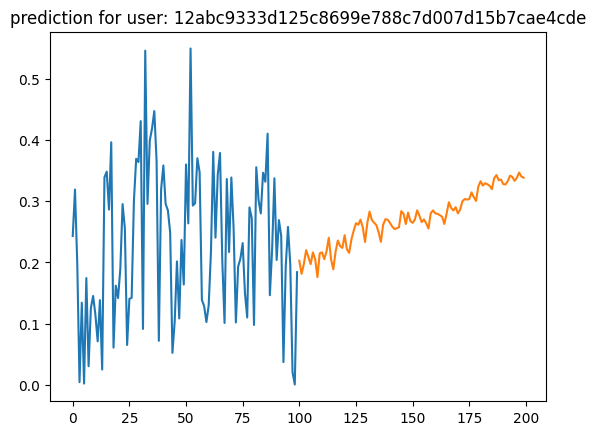

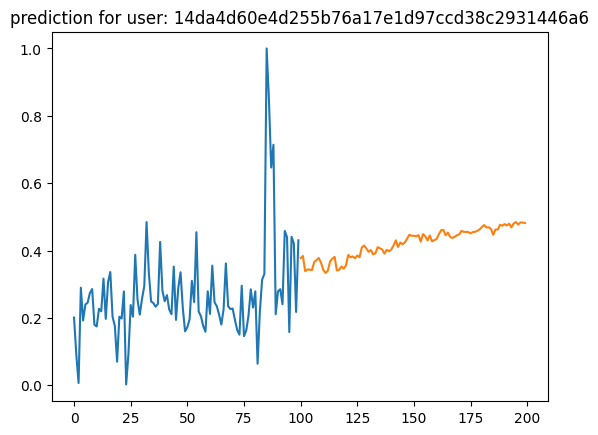

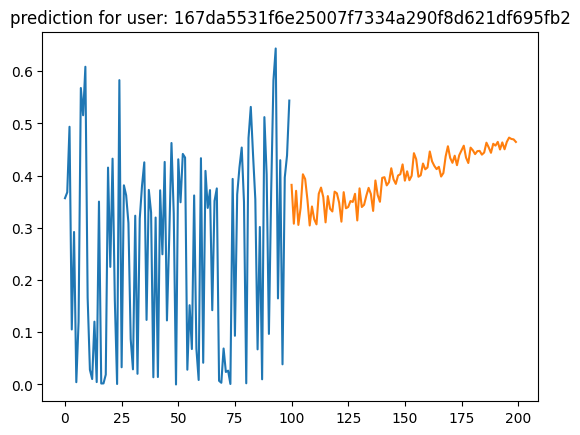

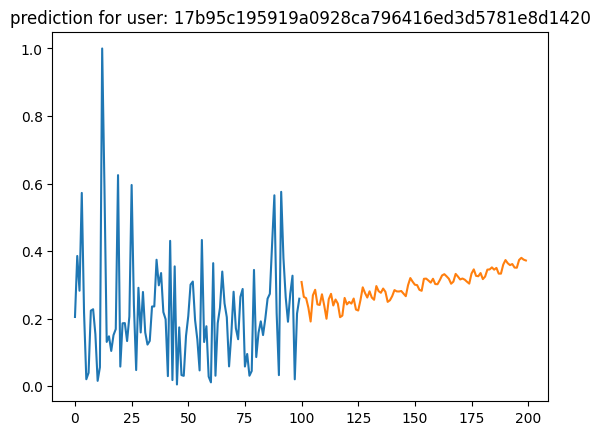

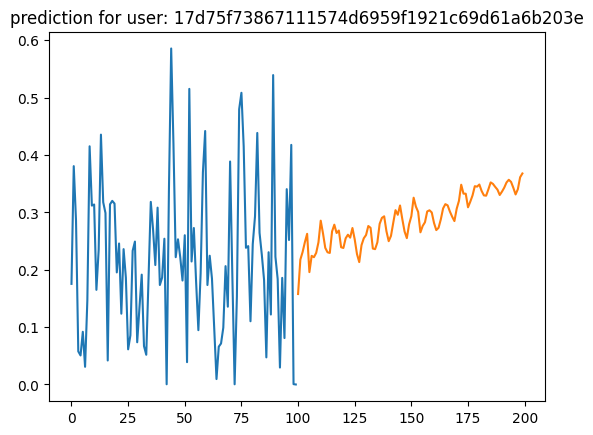

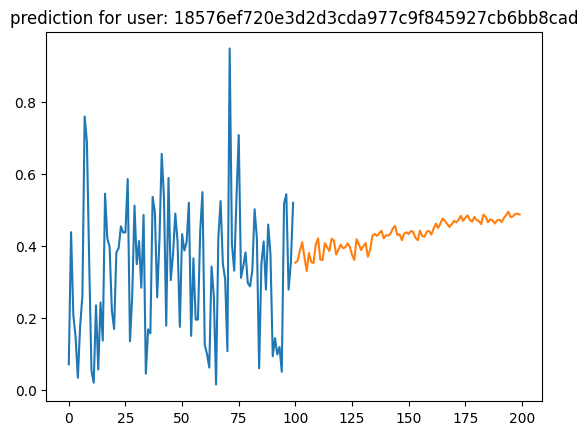

KeyboardInterrupt: 

In [17]:
for uuid,group in steps.groupby('uuid'):
    if len(group)<window:
        continue
    actual=group[-window:].values
    pred=[]
    dati=group[-window:].values
    for i in range(window):
        pred.append(model.predict(
            np.array([dati]),verbose=0
        ))
        dati = np.concatenate((dati, pred[-1]))[-window:]
    pred=np.array(pred).flatten()
    plt.title("prediction for user: "+uuid)
    plt.plot([i for i in range(len(actual))],actual,label='Actual')
    plt.plot([i+len(actual) for i in range(len(pred))],pred,label='Predicted')
    plt.show()
    plt.close()

In [ ]:
model.save("./modello-passi.keras")

In [6]:
model=keras.saving.load_model("./modello-passi.keras")